# Знакомство с методом кластеризации K-mean с помощью пакета sklearn


Продолжим работу с набором данных из первой лабораторной работы. Напомню, что он включает в себя информацию о различиях в заработной плате между выпускниками колледжей и выпускниками средних школ в США с 1973 по 2022 год.


## Подключаем все нужные библиотеки и выводим несколько значений нашего датасета

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
import os 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
os.environ['OMP_NUM_THREADS'] = '1'
from scipy import stats
data = pd.read_csv("college_wage_premium.csv",index_col=0)
data.head()

,high_school,bachelors_degree,men_high_school,men_bachelors_degree,women_high_school,women_bachelors_degree
year,,,,,,
2022,21.94,41.60,24.08,49.01,18.93,34.39
2021,22.28,41.32,24.36,47.83,19.36,35.08
2020,22.70,41.65,25.09,48.15,19.35,35.41
2019,21.64,39.61,23.99,45.74,18.48,33.80
2018,21.50,38.87,23.72,44.97,18.49,33.03


## Добавим новый аттрибут

Добавим аттрибут «Salary ratio», представляющий собой отношение средней зарплаты выпускника старшей школы к средней зарплате выпускницы старшей школы.

In [42]:
data['Salary ratio'] = data['men_high_school'] / data['women_high_school']

data.head()

,high_school,bachelors_degree,men_high_school,men_bachelors_degree,women_high_school,women_bachelors_degree,Salary ratio
year,,,,,,,
2022,21.94,41.60,24.08,49.01,18.93,34.39,1.272055
2021,22.28,41.32,24.36,47.83,19.36,35.08,1.258264
2020,22.70,41.65,25.09,48.15,19.35,35.41,1.296641
2019,21.64,39.61,23.99,45.74,18.48,33.80,1.298160
2018,21.50,38.87,23.72,44.97,18.49,33.03,1.282856


## Очистим датасет

### Найдём и удалим выбросы

In [43]:
# Выбор числовых признаков для анализа выбросов
features = ["high_school", "bachelors_degree", "men_high_school", "men_bachelors_degree", "women_high_school","women_bachelors_degree", "Salary ratio"]

# Функция для определения выбросов по стандартным отклонениям
def find_outliers_std(series):
    std_dev = series.std()  # Стандартное отклонение
    mean = series.mean()  # Среднее значение
    threshold = 3  # Пороговое значение для выбросов (обычно используется ±3 стандартных отклонения)

    outliers = (series > mean + threshold * std_dev) | (series < mean - threshold * std_dev)
    return outliers.sum()

# Подсчет количества выбросов для каждого числового признака
for feature in features:
    outliers_count = find_outliers_std(data[feature])
    print(f"Количество выбросов по признаку '{feature}': {outliers_count}")

Количество выбросов по признаку 'high_school': 0
Количество выбросов по признаку 'bachelors_degree': 0
Количество выбросов по признаку 'men_high_school': 0
Количество выбросов по признаку 'men_bachelors_degree': 0
Количество выбросов по признаку 'women_high_school': 0
Количество выбросов по признаку 'women_bachelors_degree': 0
Количество выбросов по признаку 'Salary ratio': 0


В данном датасете выбросы отсутствуют.


### Найдём и удалим дубликаты

In [44]:
duplicates_count = data.duplicated().sum()
print(f"Количество дубликатов в датасете: {duplicates_count}")

Количество дубликатов в датасете: 0


В данном датасете дубликаты отсутствуют.

### Найдем и отредактируем пропущенные значения

In [45]:
missing_values_count = data.isnull().sum()
print(f"Количество пропущенных значений в каждом столбце: {duplicates_count}")

Количество пропущенных значений в каждом столбце: 0


В данном датасете пропущенные значения отсутствуют.

### Найдём кривые данные

In [46]:
# Вычисляем z-оценки для каждого признака
z_scores = np.abs((data[features_to_analyze] - data[features_to_analyze].mean()) / data[features_to_analyze].std())

# Определяем порог z-оценки, при котором считаем данные выбросами (обычно порог 3)
threshold = 3

# Удаляем строки с выбросами
num_before = len(data)
data = data[(z_scores < threshold).all(axis=1)]
num_after = len(data)

# Выводим информацию о количестве удаленных строк
removed_outliers = num_before - num_after
print(f'Удалено "кривых" данных: {removed_outliers}')

Удалено "кривых" данных: 0


В нашем датасете не было "кривых" данных. 

## Определение числа кластеров (число k)


### Графический метод

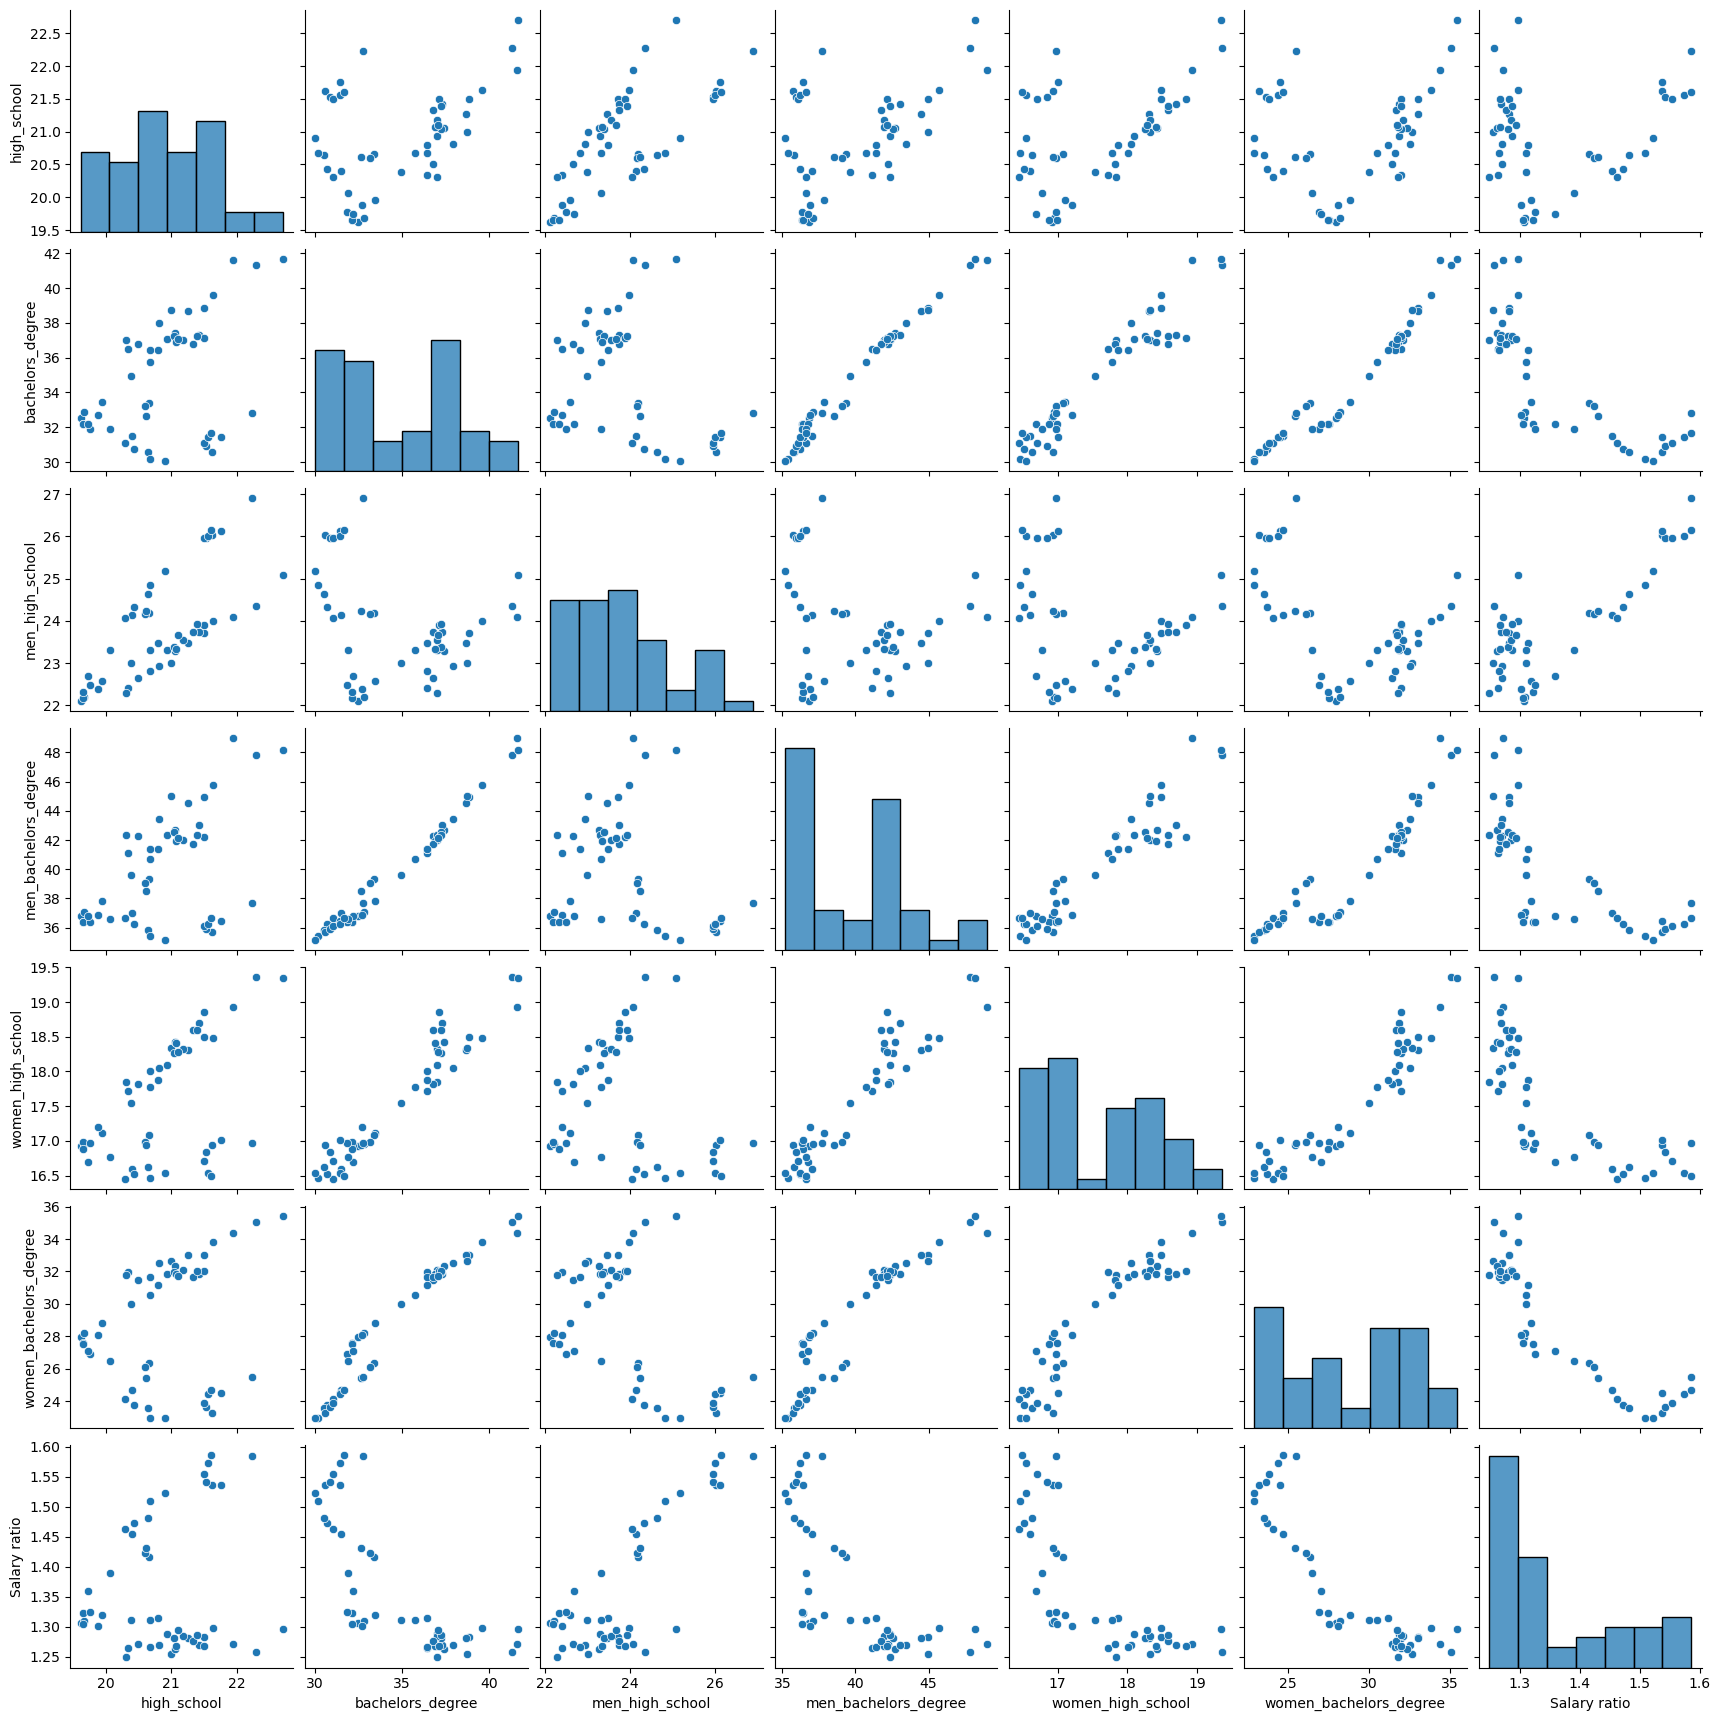

In [47]:
sns.pairplot(data)
plt.show()

Можно заметить частичное визуальное разбиение на классы на графике зависимости women_high_school от men_high_school

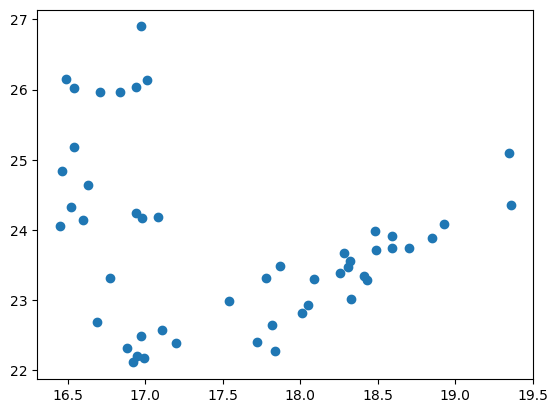

In [13]:
plt.scatter(data["women_high_school"],data["men_high_school"])

Визуально наблюдаем неявно выраженные кластеры

### Метод локтя

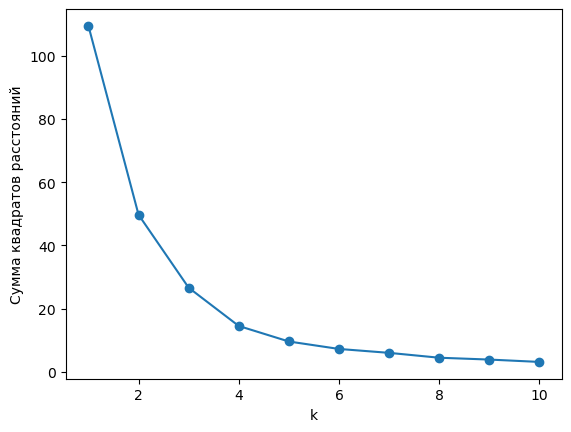

In [28]:
import warnings
warnings.filterwarnings('ignore')
k_range = range(1, 11)
sse = []
for k in k_range:
    km = KMeans(n_clusters = k, n_init = 10)
    km.fit(data[['women_high_school',"men_high_school"]])
    sse.append(km.inertia_)

plt.xlabel('k')
plt.ylabel('Сумма квадратов расстояний')

plt.plot(k_range, sse)
plt.scatter(k_range, sse)

Из графика можно понять, что k = 5 является оптимальным значением числа групп.

## Кластеризация методом K-mean

In [48]:
km = KMeans(n_clusters = 5, n_init = 10)
y_predicted = km.fit_predict(data[["women_high_school","men_high_school"]])
data["cluster"] = y_predicted
data



,high_school,bachelors_degree,men_high_school,men_bachelors_degree,women_high_school,women_bachelors_degree,Salary ratio,cluster
year,,,,,,,,
2022,21.94,41.60,24.08,49.01,18.93,34.39,1.272055,2
2021,22.28,41.32,24.36,47.83,19.36,35.08,1.258264,2
2020,22.70,41.65,25.09,48.15,19.35,35.41,1.296641,2
2019,21.64,39.61,23.99,45.74,18.48,33.80,1.298160,2
2018,21.50,38.87,23.72,44.97,18.49,33.03,1.282856,2
2017,21.26,38.65,23.47,44.50,18.31,33.01,1.281813,0
2016,21.00,38.73,23.01,44.98,18.33,32.66,1.255319,0
2015,20.81,37.96,22.93,43.47,18.05,32.54,1.270360,0
2014,20.34,36.47,22.40,41.14,17.72,31.98,1.264108,3


Text(0, 0.5, 'men_high_school')

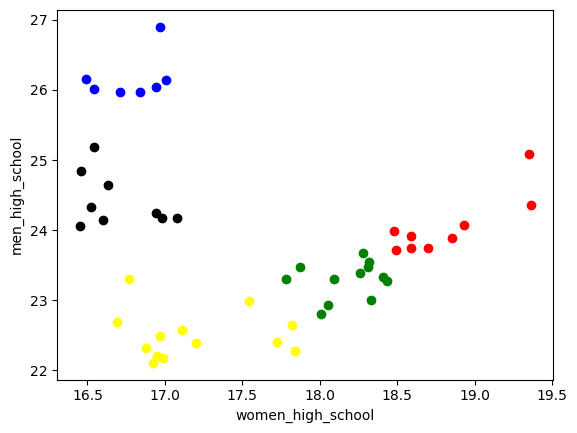

In [49]:
data1 = data[data.cluster == 0]
data2 = data[data.cluster == 1]
data3 = data[data.cluster == 2]
data4 = data[data.cluster == 3]
data5 = data[data.cluster == 4]

plt.scatter(data1["women_high_school"], data1["men_high_school"], color='green')
plt.scatter(data2["women_high_school"], data2["men_high_school"], color='blue')
plt.scatter(data3["women_high_school"], data3["men_high_school"], color='red')
plt.scatter(data4["women_high_school"], data4["men_high_school"], color='yellow')
plt.scatter(data5["women_high_school"], data5["men_high_school"], color='black')

plt.xlabel('women_high_school')
plt.ylabel('men_high_school')

Каждый цвет обозначает соответствующий ему кластер. Предположение на основании графического метода оказалось справедливым.

## Вывод

Анализируя данные о средних заработных платах выпускников и выпускниц, мы провели предварительную обработку информации и применили метод кластеризации KMeans. Используя "причесывание" данных избежали искажения данных (хотя у нас и не было выбросов и других искажений данных). Используя графические методы, мы определили оптимальное количество кластеров. Метод локтя подтвердил наше предположение о наличии пяти основных групп. Кластерный анализ выявил группы, которые благополучно отразились на графике, и подтвердил успешное разделение.